In [ ]:
! pip install scikit-plot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import numpy as np
import pandas as pd
random.seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, GRU


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.font_manager as fm
import matplotlib as mpl

fm.fontManager.addfont('/content/drive/MyDrive/times.ttf')
mpl.rcParams['font.family'] = 'Times New Roman'

import scikitplot as skplt
from tensorflow.keras.regularizers import L2

# 1. Only use text data

In [4]:
data_path = '/content/drive/MyDrive/convincing_data.csv'
data = pd.read_csv(data_path)
data['body_cleaned'] = data['body_cleaned'].apply(lambda x: x.strip('[]').replace("'",'').split(', '))
data ['text'] = data['body_cleaned'].apply(lambda x: ' '.join(x))
data = data[['id','text','sentiment']]

# 2. Sentiment threshold is +- 1/3

In [5]:
def score_label(score):
    if score > 1/3: return 1
    elif score < -1/3: return -1
    else: return 0
data['sentiment'] = data['sentiment'].apply(lambda x: score_label(x))

# 3. Other Preprocessing (Tokenization, Vectorization, Categorization, Train-test split)

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer


texts = data['text']
labels = data['sentiment'] 

max_len = 500 
vocab_size = 10000 
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
d = pad_sequences(sequences, maxlen=max_len)

labels = to_categorical(labels,num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(d, labels, test_size=0.1, random_state=42)

# 4. Model Training & Evaluation

In [7]:

def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01) 
    
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.val_losses = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

history = LossHistory()

required_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, min_delta= 0, restore_best_weights = True),
    tf.keras.callbacks.LearningRateScheduler(custom_scheduler),
    tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 10, verbose = 1, cooldown = 5, min_lr = 0.00001),
    tf.keras.callbacks.TerminateOnNaN(),
    history
]

## 4.1 GRU

### 4.1.1 Model Training

In [8]:
model = Sequential(name='gru')
model.add(Embedding(vocab_size, 64, input_length=max_len))
model.add(GRU(32, dropout=0.3, return_sequences=True, kernel_regularizer=L2(0.5)))
model.add(GRU(16, dropout=0.2,kernel_regularizer=L2(0.05)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, epochs=50, batch_size=1000, validation_split=0.1,callbacks = required_callbacks)


Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 gru (GRU)                   (None, 500, 32)           9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 651,859
Trainable params: 651,859
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
575/575 [==============================] - 110s 175ms/step - loss: 4.9340 - accuracy: 0.6492 - val_loss: 0.6869 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 2/50
575/575 [==========

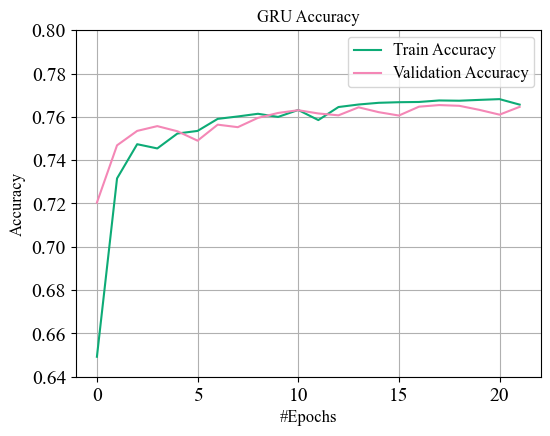

In [12]:
train_loss = history.losses
val_loss = history.val_losses
train_acc = history.accuracy
val_acc= history.val_accuracy
epochs = [i for i in range(len(history.losses))]

method = 'GRU' #method name
plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_acc, color="#0DAB76", label="Train Accuracy", linewidth=1.5)
plt.plot(epochs, val_acc, color="#F487B6", label="Validation Accuracy", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
#plt.xlim(0, 48) # range of x
plt.ylim(0.64, 0.80) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Accuracy')

plt.savefig('./'+method+'_acc.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()

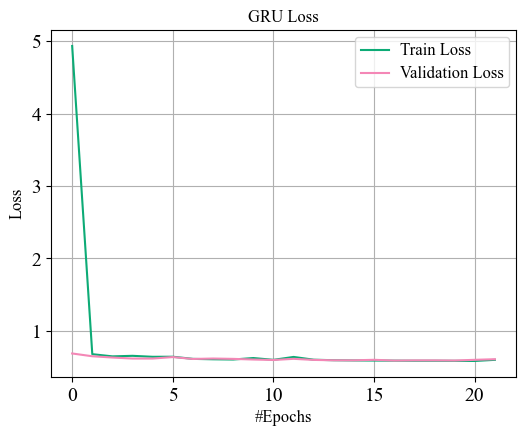

In [25]:
plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_loss, color="#0DAB76", label="Train Loss", linewidth=1.5)
plt.plot(epochs, val_loss, color="#F487B6", label="Validation Loss", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
#plt.xlim(0, 48) # range of x
#plt.ylim(0.5, 1.0) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Loss')

plt.savefig('./' + method + '_loss.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()

In [ ]:
gru_model = '/content/drive/MyDrive/gru_model'
model.save(gru_model)

### 4.1.2 Evaluation on test data

In [27]:
predict=model.predict(X_test) 
y_predict=np.argmax(predict,axis=1)-1
y_true=np.argmax(y_test,axis=1)-1
print(classification_report(y_true, y_predict))

2217/2217 [==============================] - 27s 12ms/step
              precision    recall  f1-score   support

          -1       0.55      0.39      0.45     11900
           0       0.80      0.83      0.82     29242
           1       0.79      0.85      0.82     29782

    accuracy                           0.77     70924
   macro avg       0.71      0.69      0.70     70924
weighted avg       0.75      0.77      0.76     70924



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

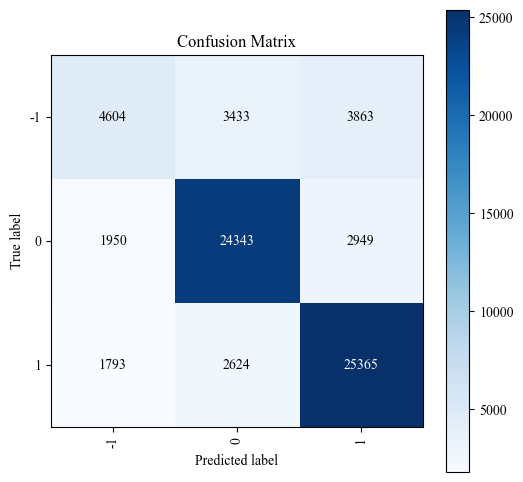

In [29]:
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_predict,
    figsize=(6,6),x_tick_rotation=90)

## 4.2 Bidirectional-GRU

### 4.2.1 Model Training

In [38]:
model_BGRU = Sequential()
model_BGRU.add(Embedding(vocab_size, 64, input_length=max_len))
model_BGRU.add(SpatialDropout1D(0.25))
model_BGRU.add(Bidirectional(GRU(32,dropout=0.3,return_sequences = True, kernel_regularizer=L2(0.4))))
model_BGRU.add(Bidirectional(GRU(16,dropout=0.2)))
model_BGRU.add(Dense(3, activation='softmax'))
model_BGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_BGRU.summary()
model_BGRU.fit(X_train, y_train, epochs=50, batch_size=1000, validation_split=0.1,callbacks = required_callbacks)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 64)           640000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 500, 64)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 500, 64)          18816     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               7872      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                      

In [39]:
train_loss = history.losses
val_loss = history.val_losses
train_acc = history.accuracy
val_acc= history.val_accuracy
epochs = [i for i in range(len(history.losses))]

method = 'Bidirectional-GRU' #method name

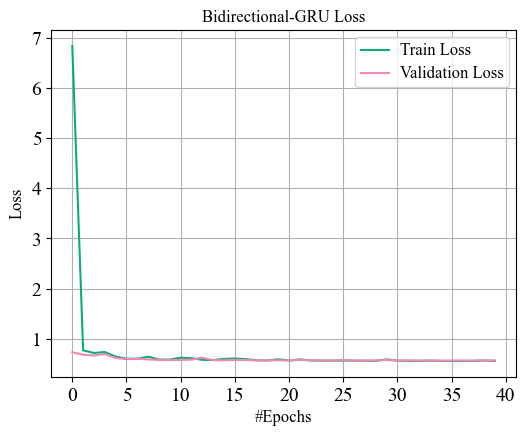

In [40]:
plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_loss, color="#0DAB76", label="Train Loss", linewidth=1.5)
plt.plot(epochs, val_loss, color="#F487B6", label="Validation Loss", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
#plt.xlim(0, 48) # range of x
#plt.ylim(0, 50) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Loss')

plt.savefig('./' + method + '_loss.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()

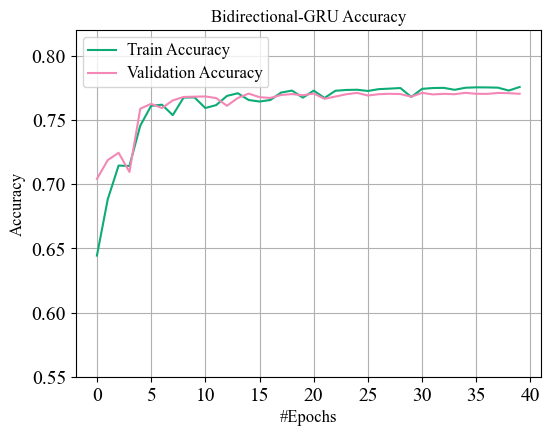

In [48]:
plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_acc, color="#0DAB76", label="Train Accuracy", linewidth=1.5)
plt.plot(epochs, val_acc, color="#F487B6", label="Validation Accuracy", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
#plt.xlim(0, 48) # range of x
plt.ylim(0.55, 0.82) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Accuracy')

plt.savefig('./'+method+'_acc.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()



In [42]:
bidirectional_gru_model = '/content/drive/MyDrive/bid_gru_model'
model_BGRU.save(bidirectional_gru_model)

### 4.2.2 Evaluation on test data

In [43]:
predict=model_BGRU.predict(X_test) 
y_predict=np.argmax(predict,axis=1)-1
print(classification_report(y_true, y_predict))

2217/2217 [==============================] - 47s 20ms/step
              precision    recall  f1-score   support

          -1       0.58      0.38      0.46     11900
           0       0.79      0.85      0.82     29242
           1       0.80      0.85      0.82     29782

    accuracy                           0.77     70924
   macro avg       0.72      0.69      0.70     70924
weighted avg       0.76      0.77      0.76     70924



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

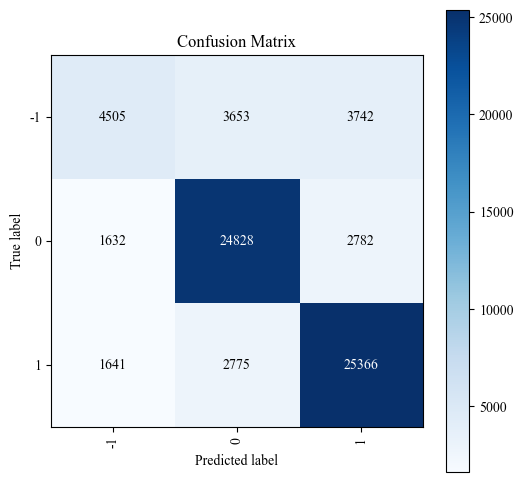

In [45]:
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_predict,
    figsize=(6,6),x_tick_rotation=90)